<a href="https://colab.research.google.com/github/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/Tutorials/Planet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial for Neural Network Verification using Planet



---

*As an example we try to verify the adversarial robustness of a classification Network trained on the MNIST dataset. The model is trained using [Caffe](https://caffe.berkeleyvision.org/) and the verification is done with [Planet](https://arxiv.org/abs/1705.01320).*

---




# Install Planet
[Github Repository](https://github.com/progirep/planet)

To verify neural networks with planet, we first clone the planet Repository from github to obtain planet.

In [ ]:
%%capture

# Clone the repo
!git clone https://github.com/progirep/planet.git

We need a script to convert the neural network description in to the "prototxt" format (produced by Caffe) into a json file, so we download it as well.
Similarly we download a second script to generate a database in HDF5 format from comma-separated value files

In [ ]:
%%capture

!cd tools
!wget https://gist.github.com/progirep/fd7d2dc120862faa984a70f503611013/raw/260e1e76cebd0ea58bf1a03b64c3f1e0002fc677/csv_to_hdf5_supervised_classification.py 

!wget https://raw.githubusercontent.com/vadimkantorov/caffemodel2json/3a8fd443bf1596dad5f517aecdef08a81bf73bfe/caffemodel2json.py

Next we intall the needed packages in order to build PLANET.

In [ ]:
%%capture

# install packages in order to build PLANET
!sudo apt-get install libglpk-dev
!sudo apt-get install qt5-qmake
!sudo apt-get install valgrind
!sudo apt-get install libltdl-dev
!sudo apt-get install protobuf-compiler

Now we can change into the src directory and trigger the build process with make.

In [ ]:
%%capture

# compile the source code
%cd planet/src
%ls
!qmake Tool.pro
!make

# Install Caffe - Currently not working in Python

Following [this tutorial](https://colab.research.google.com/github/Huxwell/caffe-colab/blob/main/caffe_details.ipynb). Caution: this takes 5 minutes.

We now install Caffe and Yices using apt.

In [ ]:
# Caffe currently doesnt work in Python, but you can train your model on cli.

%%capture

# install Caffe and Yices
# change root path of #CAFFE and #YICES
!sudo apt install caffe-cuda
!sudo add-apt-repository ppa:sri-csl/formal-methods -qq
!sudo apt-get update
!sudo apt-get install yices2

In [ ]:
%cd /content/
!git clone https://github.com/BVLC/caffe.git

We also install the needed libraries.

In [ ]:
%%capture 
!sudo apt-get install libgflags2.2 
!sudo apt-get install libgflags-dev
!sudo apt-get install libgoogle-glog-dev
!sudo apt-get install libhdf5-100
!sudo apt-get install libhdf5-serial-dev
!sudo apt-get install libhdf5-dev
!sudo apt-get install libhdf5-cpp-100
!sudo apt-get install libprotobuf-dev protobuf-compiler

In [ ]:
!find /usr -iname "*hdf5.so"
# got: /usr/lib/x86_64-linux-gnu/hdf5/serial
!find /usr -iname "*hdf5_hl.so"

To use the shared libraries for hdf5, we create symbolic links.

In [ ]:
!ln -s /usr/lib/x86_64-linux-gnu/libhdf5_serial.so /usr/lib/x86_64-linux-gnu/libhdf5.so
!ln -s /usr/lib/x86_64-linux-gnu/libhdf5_serial_hl.so /usr/lib/x86_64-linux-gnu/libhdf5_hl.so

We set the path for our HDF5 libs

In [ ]:
#!find /usr -iname "*hdf5.h*" # got:
# /usr/include/hdf5/serial/hdf5.h 
# /usr/include/opencv2/flann/hdf5.h
# Let's try the first one.
%env CPATH="/usr/include/hdf5/serial/"
#fatal error: hdf5.h: No such file or directory

In [ ]:
%%capture
!sudo apt-get install libleveldb-dev
!sudo apt-get install libgflags-dev libgoogle-glog-dev liblmdb-dev
!sudo apt-get install libsnappy-dev

Build caffe from source files.

In [ ]:
!echo $CPATH

We now change into the Coffe directory and build the shared Coffe libraries as well as the CPP object files

In [ ]:
%cd caffe

!ls
!make clean
!cp Makefile.config.example Makefile.config

In [ ]:
!sed -i 's/-gencode arch=compute_20/#-gencode arch=compute_20/' Makefile.config #old cuda versions won't compile 
!sed -i 's/\/usr\/local\/include/\/usr\/local\/include \/usr\/include\/hdf5\/serial\//'  Makefile.config #one of the 4 things needed to fix hdf5 issues
!sed -i 's/# OPENCV_VERSION := 3/OPENCV_VERSION := 3/' Makefile.config #We actually use opencv 4.1.2, but it's similar enough to opencv 3.
!sed -i 's/code=compute_61/code=compute_61 -gencode=arch=compute_70,code=sm_70 -gencode=arch=compute_75,code=sm_75 -gencode=arch=compute_75,code=compute_75/' Makefile.config #support for new GPUs

In [ ]:
!make all -j 4 # -j would use all availiable cores, but RAM related errors occur

We should now see the newly created shared libraries and Caffe object files.

In [ ]:
!find / -iname "*caffe*"

# Train Caffe model on MNIST

To train our model, we have to download the mnist dataset.

In [ ]:
# downloads mnist dataset

%cd /content/caffe/

!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz
!cp -rv MNIST/raw/* data/mnist/

In [ ]:
# creates mnist_test_lmdb and mnist_train_lmdb

!/content/caffe/examples/mnist/create_mnist.sh

Now we copy the output to the corresponding folder.

In [ ]:
# copy lmdbs to planet folder

%cp -a /content/caffe/examples/mnist/mnist_test_lmdb /content/planet/casestudies/MNIST/
%cp -a /content/caffe/examples/mnist/mnist_train_lmdb /content/planet/casestudies/MNIST/

### Define our neural network

Now we define the net and its structure with the individual layers.

In [ ]:
%%writefile /content/lenet_train_test.prototext
name: "LeNet"
layer {
  name: "mnist"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TRAIN
  }
  transform_param {
    scale: 0.00390625
  }
  data_param {
    source: "mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "mnist"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TEST
  }
  transform_param {
    scale: 0.00390625
  }
  data_param {
    source: "mnist_test_lmdb"
    batch_size: 100
    backend: LMDB
  }
}

layer {
    name: "reshapeA"
    type: "Reshape"
    bottom: "data"
    top: "reshapeA"
    reshape_param {
      shape {
        dim: -1  # copy the dimension from below
        dim: 1  # copy the dimension from below
        dim: 28  # copy the dimension from below
        dim: 28 # infer it from the other dimensions
      }
    }
}

layer {
  name: "conv1"
  type: "Convolution"
  bottom: "reshapeA"
  top: "conv1"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  convolution_param {
    num_output: 3
    kernel_size: 4
    stride: 2
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 4
    stride: 3
  }
}

layer {
    name: "reshapeB"
    type: "Reshape"
    bottom: "pool1"
    top: "reshapeB"
    reshape_param {
      shape {
        dim: -1  # copy the dimension from below
        dim: 48 # infer it from the other dimensions
      }
    }
}

layer {
  name: "ip1"
  type: "InnerProduct"
  bottom: "reshapeB"
  top: "ip1"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  inner_product_param {
    num_output: 8
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "ip1"
  top: "relu1"
}
layer {
  name: "ip2"
  type: "InnerProduct"
  bottom: "relu1"
  top: "ip2"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  inner_product_param {
    num_output: 10
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "accuracy"
  type: "Accuracy"
  bottom: "ip2"
  bottom: "label"
  top: "accuracy"
}
layer {
  name: "loss"
  type: "SoftmaxWithLoss"
  bottom: "ip2"
  bottom: "label"
  top: "loss"
}

### Define our training 

In [ ]:
%%writefile /content/lenet_solver.prototxt
# The train/test net protocol buffer definition
net: "lenet_train_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 1000
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 1000
# The maximum number of iterations
max_iter: 20000
# solver mode: CPU or GPU
solver_mode: CPU

### Train our model using Caffe

In [ ]:
# train the model
!/content/caffe/build/tools/caffe train --solver=/content/lenet_solver.prototxt $@

The training results in a .caffemodel file, which now describes our trained model. To verify it with PLANET, we have to convert it to the right input format:

*.caffemodel -> .json -> .rlv*

# Convert Caffe model to Planet input file

In [ ]:
%cd /content/caffe/
!make pycaffe
!make distribute

In [ ]:
%env CAFFE_ROOT=/content/caffe
%env PYTHONPATH=/content/caffe/python:$PYTHONPATH

Here we run into a problem; Caffe does not find the previously generated shared object file _caffe.so, which is wrapped in Python code using python 2.7. Therefore even changing the directory leads to a compatibility issue with the Python 2.7 compiled .so file and our Code in Python 3.

Therefore we have to download the corresponding file and run this offline with python 2.7. The corresponding output file can thean be upoaded again and fed into the next steps.

In [ ]:
import os
import sys
import json
import requests
import argparse
import tempfile
import subprocess
from google.protobuf.descriptor import FieldDescriptor as FD

# inspired by https://github.com/dpp-name/protobuf-json/blob/master/protobuf_json.py
def pb2json(pb, print_arrays):
	_ftype2js = {
		FD.TYPE_DOUBLE: float,
		FD.TYPE_FLOAT: float,
		FD.TYPE_INT64: long,
		FD.TYPE_UINT64: long,
		FD.TYPE_INT32: int,
		FD.TYPE_FIXED64: float,
		FD.TYPE_FIXED32: float,
		FD.TYPE_BOOL: bool,
		FD.TYPE_STRING: unicode,
		FD.TYPE_BYTES: lambda x: x.encode('string_escape'),
		FD.TYPE_UINT32: int,
		FD.TYPE_ENUM: int,
		FD.TYPE_SFIXED32: float,
		FD.TYPE_SFIXED64: float,
		FD.TYPE_SINT32: int,
		FD.TYPE_SINT64: long,
		FD.TYPE_MESSAGE: lambda x: pb2json(x, print_arrays = print_arrays),
		'unknown' : lambda x: 'Unknown field type: %s' % x
	}
	js = {}
	for field, value in pb.ListFields():
		ftype = _ftype2js[field.type] if field.type in _ftype2js else _ftype2js['unknown']
		if field.label == FD.LABEL_REPEATED:
			js_value = map(ftype, value)
			if not print_arrays and (field.name == 'data' and len(js_value) > 8):
				head_n = 5
				js_value = js_value[:head_n] + ['(%d elements more)' % (len(js_value) - head_n)]
		else:
			js_value = ftype(value)
		js[field.name] = js_value
	return js

from caffe import *

caffemodel_file = '/content/planet/casestudies/MNIST/lenet_solver_iter_50000.caffemodel'

deserialized = caffe_pb2.NetParameter()
deserialized.ParseFromString(open(caffemodel_file, 'rb').read())

json.dump(pb2json(deserialized, args.data), sys.stdout, indent = 2)


## Caffe to JSON converter in Python3
### TODO caffe doesnt work in python currently



In [ ]:
import os
import sys
import json
import argparse
import tempfile
import subprocess
from google.protobuf.descriptor import FieldDescriptor as FD

# inspired by https://github.com/dpp-name/protobuf-json/blob/master/protobuf_json.py
def pb2json(pb, print_arrays):
	_ftype2js = {
        FD.TYPE_DOUBLE: float,
		FD.TYPE_FLOAT: float,
		FD.TYPE_INT64: int,
		FD.TYPE_UINT64: int,
		FD.TYPE_INT32: int,
		FD.TYPE_FIXED64: float,
		FD.TYPE_FIXED32: float,
		FD.TYPE_BOOL: bool,
		FD.TYPE_STRING: str,
		FD.TYPE_BYTES: lambda x: x.encode('string_escape'),
		FD.TYPE_UINT32: int,
		FD.TYPE_ENUM: int,
		FD.TYPE_SFIXED32: float,
		FD.TYPE_SFIXED64: float,
		FD.TYPE_SINT32: int,
		FD.TYPE_SINT64: int,
		FD.TYPE_MESSAGE: lambda x: pb2json(x, print_arrays = print_arrays),
		'unknown' : lambda x: 'Unknown field type: %s' % x
	}
	js = {}
	for field, value in pb.ListFields():
		ftype = _ftype2js[field.type] if field.type in _ftype2js else _ftype2js['unknown']
		if field.label == FD.LABEL_REPEATED:
			js_value = list(map(ftype, value))
			if not print_arrays and (field.name == 'data' and len(js_value) > 8):
				head_n = 5
				js_value = js_value[:head_n] + ['(%d elements more)' % (len(js_value) - head_n)]
		else:
			js_value = ftype(value)
		js[field.name] = js_value
	return js

from caffe.proto import caffe_pb2

caffe_file = "lenet_solver_iter_50000.caffemodel"

deserialized = caffe_pb2.NetParameter()
deserialized.ParseFromString(open(caffe_file, 'rb').read())

# print(deserialized)
# json dump to console
json.dump(pb2json(deserialized, "store_true"), sys.stdout, indent = 2)

# json dump to file
with open("caffemodel_mnist.json", "w") as f:
    json.dump(pb2json(deserialized, "store_true"), f, indent = 2)

## JSON to RLV converter in Python3

The next step is to covert the output in JSON format into the RLV format which can be red by planet. For this we simply use the script from the original author and rewrite it to work with python 3.

In [ ]:
%%capture cap --no-stderr
with open('output.rlv', 'w') as f:
    f.write(cap.stdout)

import os, sys
import json
# import operator
from functools import reduce
from pprint import pprint

# Read input file
if len(sys.argv) < 2:
    print(sys.stderr, "Error: Expected JSON input file name!")

"""
with open(sys.argv[1]) as data_file:    
    data = json.load(data_file)
"""

with open("caffemodel_mnist.json") as data_file:    
    data = json.load(data_file)

data = data["layer"]

# Neuron lookup table: layer--->Neuron names
neurons = {}


# Function for recursively processing layers
def recurseProcessLayer(dataLineName,dataLineWidth):
    '''Returns the neuron names. DataLineWidth may be unknown.'''

    # DAG Caching
    if dataLineName in neurons:
        return neurons[dataLineName]
        
    # Search for the producer of this layer
    for layer in data:
        if dataLineName in layer["top"]:

            # This is the layer to be processed
            # ---> Proceed according to type.
            if layer["type"]=="Split":
                assert len(layer["bottom"])==1
                return recurseProcessLayer(layer["bottom"][0],dataLineWidth)
            elif layer["type"]=="InnerProduct":
                
                # Get output dimension
                outputLineWidth = layer["inner_product_param"]["num_output"]
                if dataLineWidth!=None:
                    assert outputLineWidth==dataLineWidth
                
                # Now get input dimension and blob data
                inputLineWidth = None
                biasWeights = None
                inputWeights = None
                for blob in layer["blobs"]:
                    if len(blob["shape"]["dim"])==1:
                        biasWeights = blob["data"]
                    elif len(blob["shape"]["dim"])==2:
                        inputLineWidth = blob["shape"]["dim"][1]
                        inputWeights = blob["data"]
                        assert blob["shape"]["dim"][0]==outputLineWidth
                    else:
                        assert False
                assert inputLineWidth != None
                
                # Now get input
                assert len(layer["bottom"])==1
                inputNeurons = recurseProcessLayer(layer["bottom"][0],inputLineWidth)
                
                # Produce outputs
                outputNeurons = []
                for i in range(0,outputLineWidth):
                    outputNeurons.append(dataLineName+"X"+str(i))
                    sys.stdout.write("Linear "+dataLineName+"X"+str(i)+" "+str(biasWeights[i]))
                    for j in range(0,len(inputNeurons)):
                        sys.stdout.write(" "+str(inputWeights[i*inputLineWidth+j])+" "+str(inputNeurons[j]))
                    sys.stdout.write("\n")
                
                neurons[dataLineName] = outputNeurons
                return outputNeurons
                
                
            elif layer["type"]=="ReLU":
            
                # RELU: Get Input
                assert len(layer["bottom"])==1
                inputNeurons = recurseProcessLayer(layer["bottom"][0],dataLineWidth)
                
                # Produce outputs
                outputNeurons = []
                for i in range(0,len(inputNeurons)):
                    outputNeurons.append(dataLineName+"X"+str(i))
                    sys.stdout.write("ReLU "+dataLineName+"X"+str(i)+" 0.0 1.0 "+str(inputNeurons[i])+"\n")
                
                neurons[dataLineName] = outputNeurons
                return outputNeurons
                
                
                
            elif layer["type"]=="Convolution":
                
                # Convolution
                
                # ---> Load weights and biasses
                dimWeights = None
                weights = None
                biasses = None
                for blob in layer["blobs"]:
                    size = blob["shape"]["dim"]
                    params = blob["data"]
                    if len(size)==1:
                        biasses = params
                    else:
                        dimWeights = size
                        weights = params
                        
                # ---> Other parameters
                #--------> Read Stride
                if "stride" in layer["convolution_param"]:
                    stride = layer["convolution_param"]["stride"]
                    assert len(stride)==1
                    stride = stride + stride
                else:
                    if "stride_w" in layer["convolution_param"]:
                        if "stride_h" in layer["convolution_param"]:
                            stride = [layer["convolution_param"]["stride_w"],layer["convolution_param"]["stride_h"]]
                        else:
                            stride = [layer["convolution_param"]["stride_w"],1]
                    else:
                        if "stride_h" in layer["convolution_param"]:
                            stride = [1,layer["convolution_param"]["stride_h"]]
                        else:
                            stride = [1,1]
                
                #--------> Read Kernel Size
                if "kernel_size" in layer["convolution_param"]:
                    kernel_size = layer["convolution_param"]["kernel_size"]
                    assert len(kernel_size)==1
                    kernel_size = kernel_size + kernel_size
                else:
                    kernel_size = [layer["convolution_param"]["kernel_w"],layer["convolution_param"]["kernel_h"]]

                #--------> Read PAD
                if "pad" in layer["convolution_param"]:
                    padding = layer["convolution_param"]["pad"]
                    assert len(padding)==1
                    padding = padding + padding
                else:
                    if "pad_w" in layer["convolution_param"]:
                        if "pad_h" in layer["convolution_param"]:
                            padding = [layer["convolution_param"]["pad_w"],layer["convolution_param"]["pad_h"]]
                        else:
                            padding = [layer["convolution_param"]["pad_w"],0]
                    else:
                        if "pad_h" in layer["convolution_param"]:
                            padding = [0,layer["convolution_param"]["pad_h"]]
                        else:
                            padding = [0,0]

                num_output = layer["convolution_param"]["num_output"]
                num_input_channels = dimWeights[1]
                
                # Rest is unimplemented for the time being.
                # assert dimWeights[0]==1 #---> This is for the *outgoing* num_outputs
                # assert dimWeights[1]==1 #----> This is for the incoming colors or features
                
                # Check for some unsupported features
                if "bias_term" in layer["convolution_param"]:
                    print(sys.stderr, "Error: Only the default 'bias_term' value is supported for convolution layers")
                    sys.exit(1)

                if "group" in layer["convolution_param"]:
                    print(sys.stderr, "Error: Only the default 'group' value is supported for convolution layers")
                    sys.exit(1)
                
                # ---> Read input
                inputNeurons = recurseProcessLayer(layer["bottom"][0],None)
                
                # ---> Unflatten weights
                def unflatten(neurons,remainingDimensions):
                    if len(remainingDimensions)==1:
                        return (neurons[0:remainingDimensions[0]],neurons[remainingDimensions[0]:])
                    else:
                        res = []
                        for a in range(0,remainingDimensions[0]):
                            (d,neurons) = unflatten(neurons,remainingDimensions[1:])
                            res.append(d)
                        return (res,neurons)
                
                (unflattenedWeights,rest) = unflatten(weights,dimWeights)
                assert rest==[]
                
                # Compute convolution
                resultingNeurons = []
                for i in range(0,num_output):
                    ysize = len(inputNeurons[0])
                    xsize = len(inputNeurons[0][0])
                    thisBlock = []
                    for y in range(-1*padding[1],ysize-kernel_size[1]+1+padding[1],stride[1]):
                        thisLine = []                    
                        for x in range(-1*padding[0],xsize-kernel_size[0]+1+padding[0],stride[0]):
                            thisLine.append(dataLineName+"X"+str(i)+"X"+str(x)+"X"+str(y))
                            localInputs = []
                            for c in range(0,num_input_channels):
                                for b in range(0,kernel_size[1]):
                                    for a in range(0,kernel_size[0]):
                                        if y+b>=0 and y+b<len(inputNeurons[c]):
                                            if x+a>=0 and x+a<len(inputNeurons[c][y+b]):
                                                localInputs.append(str(unflattenedWeights[i][c][b][a])+" "+inputNeurons[c][y+b][x+a]) 
                            sys.stdout.write("Linear "+thisLine[-1]+" "+str(biasses[i])+" "+" ".join(localInputs)+"\n")
                        thisBlock.append(thisLine)
                    resultingNeurons.append(thisBlock)
                    
                return resultingNeurons

            elif layer["type"]=="HDF5Data":
            
                # Input layer
                assert dataLineWidth!=None
                
                outputNeurons = []
                for i in range(0,dataLineWidth):
                    outputNeurons.append("inX"+str(i))
                    sys.stdout.write("Input inX"+str(i)+"\n")

                neurons[dataLineName] = outputNeurons
                return outputNeurons
                
            elif layer["type"]=="Data":
            
                # Input layer
                assert dataLineWidth!=None
                
                # We assume normalization by a factor of 1/256.0 here.
                assert layer['transform_param']['scale'] == 0.00390625

                outputNeurons = []
                for i in range(0,dataLineWidth):
                    outputNeurons.append("inX"+str(i))
                    sys.stdout.write("Input inX"+str(i)+"\n")

                neurons[dataLineName] = outputNeurons
                return outputNeurons
                
            elif layer["type"]=="Reshape":
            
                # Reshape layer
                outputDimension = layer['reshape_param']['shape']['dim']
                # print layer
                assert outputDimension[0]==-1 # The first dimension is always the sample points
                
                nofInputs = 1
                for a in outputDimension[1:]:
                    nofInputs *= a
                inputNeurons = recurseProcessLayer(layer["bottom"][0],nofInputs)

                
                # Ok, first flatten input Neurons
                def flat(neurons):
                    if type(neurons)==str or type(neurons)==str:
                        return [neurons]
                    else:
                        l = []
                        for a in neurons:
                            l.extend(flat(a))
                        return l
                
                # Ok, first flatten input Neurons
                #def flat(neurons):
                #    if type(neurons)==str or type(neurons)==unicode or type(neurons)==int:
                #        return [neurons]
                #    else:
                #        l = []
                #        for a in neurons:
                #            l.append(flat(a))
                #        return [a for j in zip(*l) for a in j ]

                flattenedNeurons = flat(inputNeurons)
                
                # Ok, now reshape
                def unflatten(neurons,remainingDimensions):
                    if len(remainingDimensions)==1:
                        return (neurons[0:remainingDimensions[0]],neurons[remainingDimensions[0]:])
                    else:
                        res = []
                        for a in range(0,remainingDimensions[0]):
                            (d,neurons) = unflatten(neurons,remainingDimensions[1:])
                            res.append(d)
                        return (res,neurons)
                
                # Ok, now reshape
                #def unflatten(neurons,selection,dimensions):
                #    if len(selection)==len(dimensions):
                #        index = 0
                #        factor = 1
                #        for i in range(0,len(selection)):
                #            index += factor*selection[i]
                #            factor *= dimensions[i]
                #        return neurons[index]
                #    else:
                #        res = []
                #        for a in range(0,dimensions[len(selection)]):
                #            res.append(unflatten(neurons,selection+[a],dimensions))
                #        return res

                
                (unflattenedNeurons,rest) = unflatten(flattenedNeurons,outputDimension[1:])
                assert rest==[]
                # print outputDimension
                # print inputNeurons
                # print flattenedNeurons
                # print "-----UF:->",unflattenedNeurons
                assert len(flattenedNeurons)==reduce(operator.mul, outputDimension[1:], 1)
                              
                return unflattenedNeurons

            elif layer["type"]=="Pooling":
            
                # Reshape layer
                inputNeurons = recurseProcessLayer(layer["bottom"][0],None)
                
                assert layer["pooling_param"]["pool"]==0 # Must be a MAXPOOL (for the time being)
                
                # ---> Other parameters
                #--------> Read Stride
                if "stride" in layer["pooling_param"]:
                    # Why is the "stride" here an int, but for the Convolution layer is a list?
                    stride = layer["pooling_param"]["stride"]
                    if isinstance(stride,list):
                        assert len(stride)==1
                        stride = stride + stride
                    else:
                        stride = [stride,stride]
                else:
                    if "stride_w" in layer["pooling_param"]:
                        if "stride_h" in layer["pooling_param"]:
                            stride = [layer["pooling_param"]["stride_w"],layer["pooling_param"]["stride_h"]]
                        else:
                            stride = [layer["pooling_param"]["stride_w"],1]
                    else:
                        if "stride_h" in layer["pooling_param"]:
                            stride = [1,layer["pooling_param"]["stride_h"]]
                        else:
                            stride = [1,1]
                
                #--------> Read Kernel Size
                if "kernel_size" in layer["pooling_param"]:
                    # Why is the "kernel_size" here an int, but for the Convolution layer is a list?
                    kernel_size = layer["pooling_param"]["kernel_size"]
                    if isinstance(kernel_size,list):
                        assert len(kernel_size)==1
                        kernel_size = kernel_size + kernel_size
                    else:
                        kernel_size = [kernel_size,kernel_size]
                else:
                    kernel_size = [layer["pooling_param"]["kernel_w"],layer["pooling_param"]["kernel_h"]]

                #--------> Read PAD
                if "pad" in layer["pooling_param"]:
                    padding = layer["pooling_param"]["pad"]
                    assert len(padding)==1
                    padding = padding + padding
                else:
                    if "pad_w" in layer["pooling_param"]:
                        if "pad_h" in layer["pooling_param"]:
                            padding = [layer["pooling_param"]["pad_w"],layer["pooling_param"]["pad_h"]]
                        else:
                            padding = [layer["pooling_param"]["pad_w"],0]
                    else:
                        if "pad_h" in layer["pooling_param"]:
                            padding = [0,layer["pooling_param"]["pad_h"]]
                        else:
                            padding = [0,0]

                
                # Here, we assume that the "inputNeurons" array is three-dimensional:
                # - color channel
                # - X channel
                # - Y channel
                resultingNeurons = []
                for i,channel in enumerate(inputNeurons):
                    ysize = len(channel)
                    xsize = len(channel[0])
                    thisBlock = []
                    for y in range(-1*padding[1],ysize-kernel_size[1]+1+padding[1],stride[1]):
                        thisLine = []                    
                        for x in range(-1*padding[0],xsize-kernel_size[0]+1+padding[0],stride[0]):
                            thisLine.append(dataLineName+"X"+str(i)+"X"+str(x)+"X"+str(y))
                            localInputs = []
                            for b in range(0,kernel_size[1]):
                                for a in range(0,kernel_size[0]):
                                    if y+b>=0 and y+b<len(channel):
                                        if x+a>=0 and x+a<len(channel[y+b]):
                                            localInputs.append(channel[y+b][x+a]) 
                            sys.stdout.write("MaxPool "+thisLine[-1]+" "+" ".join(localInputs)+"\n")
                        thisBlock.append(thisLine)
                    resultingNeurons.append(thisBlock)
                return resultingNeurons                    
                    
            else:
                raise RuntimeError("Unsupported Layer Type: "+layer["type"])
            
    raise "Error: Data Line "+dataLineName+" not found."


# Process the Accuracy layer
foundAccurracyLayer = False
for layer in data:
    if layer['type'] == 'Accuracy':
        foundAccurracyLayer = True
        outputs = recurseProcessLayer(layer["bottom"][0],None)
        for i in range(0,len(outputs)):
            sys.stdout.write("Linear outX"+str(i)+" 0.0 1.0 "+outputs[i]+"\n")
                
if not foundAccurracyLayer:
    print(sys.stderr, "Warning: No 'Accuracy' layer found, hence nothing was translated.")

## Run planet with your RLV file

In the converted rlv file we now add the input constraints for our verification

In [ ]:
# Add contraints on Input Variables for Planet
%cd /content/

with open("output.rlv", "ab") as f:
  for i in range(28*28):
    linebreak = bytes("\n", "utf-8")
    assert_lowerbound = bytes("Assert <= 0.0 1.0 inX" + str(i), "utf-8")
    assert_upperbound = bytes("Assert >= 1.0 1.0 inX" + str(i), "utf-8")

    f.write(linebreak)
    f.write(assert_lowerbound)
    f.write(linebreak)
    f.write(assert_upperbound)

# Verify Robustness with Planet

In [ ]:
!pip install python-mnist

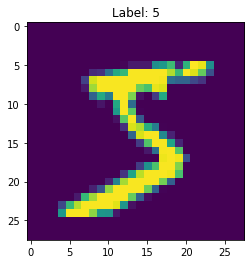

In [ ]:
from mnist import MNIST
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

data = MNIST("/content/caffe/data/mnist/")

imgs, labels = data.load_training()

img = np.asarray(imgs[0]).reshape(28, 28)
pixels = np.asarray(imgs[0])

plt.title("Label: {}".format(labels[0]))
plt.imshow(img)

In [ ]:
# download converted files
!wget https://cloudstorage.uni-oldenburg.de/s/Fs5BdYLNGtpnxq3/download/output.rlv -O /content/output.rlv
!wget https://cloudstorage.uni-oldenburg.de/s/FwYjDb9zjDE4x7W/download/caffemodel_mnist.json -O /content/caffemodel_output.json

In [ ]:
# targetDigit, maxDifferencePerPixel, maxUnsmoothnessInNoise 
# Obtain a digit image that is close to a given one, that resolves to the given target digit, 
# where every pixel is at most maxDifferencePerPixel away from the initial image 
# and the maximal noise difference between two adjacent pixels is maxUnsmoothnessInNoise. 
# The last two parameters should be >=0 and <=1 (such as, e.g., 0.05 for 5% deviation)"
maxDifferencePerPixel = 0.1
targetDigit = 5
maxUnsmoothnessInNoise = 0.05

def addBounds(i, l_bound, u_bound):
  with open("/content/output.rlv", "ab") as f:
    linebreak = bytes("\n", "utf-8")
    assert_lowerbound = bytes("Assert <= {} 1.0 inX{}".format(l_bound, i), "utf-8")
    assert_upperbound = bytes("Assert >= {} 1.0 inX{}".format(u_bound, i), "utf-8")

    f.write(linebreak)
    f.write(assert_lowerbound)
    f.write(linebreak)
    f.write(assert_upperbound)

# constraints for input neurons  
for i in range(28*28):
  # exclude outer pixels, because there are no neighbours
  x = i % 28
  y = int(i / 28)

  if x<3 or x>24 or y<3 or y>24:
    border = 0.0
  else:
    border = maxDifferencePerPixel

  lower_bound = max(0.0, pixels[i]/256.0 - border)
  upper_bound = min(1.0, pixels[i]/256.0 + border) 
  addBounds(i, lower_bound, upper_bound)

# constraints for output neurons
for i in range(10):
  if i == targetDigit:
    continue
  with open("/content/output.rlv", "ab") as f:
    assertion = "\nAssert >= -0.000001 1.0 outX{} -1.0 outX{}".format(i, targetDigit)
    f.write(bytes(assertion, "utf-8"))

# constraints for smoothness
for x in range(28):
  for y in range(28):
    if y < 27:
      pixelDiff = (pixels[y*28+x] - pixels[(y+1)*28+x]) / 256.0
      ass1 = "\nAssert <= {} 1.0 inX{} -1.0 inX{}".format((pixelDiff-maxUnsmoothnessInNoise), (y*28+x), (y+1)*28+x)
      ass2 = "\nAssert >= {} 1.0 inX{} -1.0 inX{}".format((pixelDiff+maxUnsmoothnessInNoise), (y*28+x), (y+1)*28+x)
      with open("/content/output.rlv", "ab") as f:
        f.write(bytes(ass1, "utf-8"))
        f.write(bytes(ass2, "utf-8"))
    if x < 27: 
      pixelDiff = (pixels[y*28+x] - pixels[y*28+x+1]) / 256.0
      ass1 = "\nAssert <= {} 1.0 inX{} -1.0 inX{}".format((pixelDiff-maxUnsmoothnessInNoise), (y*28+x), (y*28+x+1))
      ass2 = "\nAssert >= {} 1.0 inX{} -1.0 inX{}".format((pixelDiff+maxUnsmoothnessInNoise), (y*28+x), (y*28+x+1))
      with open("/content/output.rlv", "ab") as f:
        f.write(bytes(ass1, "utf-8"))
        f.write(bytes(ass2, "utf-8"))

print("FINISHED ADDING CONSTRAINTS!")

FINISHED ADDING CONSTRAINTS!


In [ ]:
# removes assert conditions and empty lines
!sed -i "/Assert/d" /content/output.rlv
!sed -i "/^$/d" /content/output.rlv 

Run planet and save the output in a text file, so we can parse it for values later

In [ ]:
%%capture cap --no-stderr
!/content/planet/src/planet /content/output.rlv

with open("/content/planet_output.txt", "w") as f:
  f.write(cap.stdout)

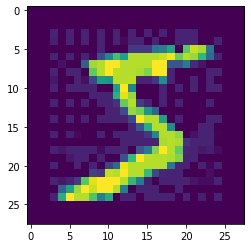

In [ ]:
sat = False
valLineFound = False
values = {}

# parse the planet output
with open("/content/planet_output.txt", "r") as f:
  for line in f.readlines():
    line = line.strip()

    if line == "SAT":
      sat = True
    elif line == "Valuation:":
      valLineFound = True
    elif line.startswith("- ") and valLineFound:
      parts = line.split(" ")
      
      assert parts[0] == "-"
      assert parts[3] == "/"

      # DEBUG prints
      # print(parts[1][:len(parts[1])-1])
      # print(parts[2])
      # break
      # builds a dictionary with the calculated values
      # e.g. values[inX0] = 0.0
      values[parts[1][:len(parts[1])-1]] = float(parts[2])

# create adverserial example
if sat:
  outImg = Image.new("L", (28, 28))
  for y in range(28):
    for x in range(28):
      outImg.putpixel((x, y), int(256*values["inX{}".format(y*28 + x)]))

  #plt.title("Label: {}".format(labels[0]))
  plt.imshow(outImg)

# Current TODO:
The Output Variables are not constrained, we probably need to do that next!